In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
from matplotlib          import rcParams
from scipy.integrate     import odeint
from scipy.optimize      import dual_annealing

plt.close('all')
sns.set_context('notebook')
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor']   = 'white'

In [2]:
def model(y, t, params):
    mRNA = y[0]
    prot = y[1]
    
    inducer = params[0]
    synm    = params[1]  
    k_ind   = params[2] 
    degm    = params[3] 
    synp    = params[4]
    mu      = params[5]
    
    dmRNA = 0
    dprot = synp*(inducer)/(inducer+k_ind)-mu*prot
    
    return np.array([dmRNA, dprot])

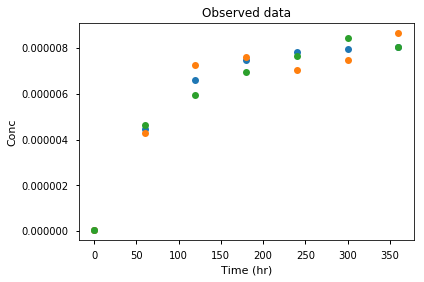

In [3]:
#Part 1: Produce a data set (evidence) and plot it
raw_data = pd.read_csv(r"C:\Users\Gerald\Desktop\School Stuff\Sem 7\FYP\Resources-master\Example_Data.csv")
tspan    = raw_data.iloc[:,0]
y_data   = raw_data.iloc[:,1:]

fig1 = plt.figure()
ax1  = fig1.add_subplot(1,1,1)
ax1.plot(tspan, y_data,'o')
setting = ax1.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')

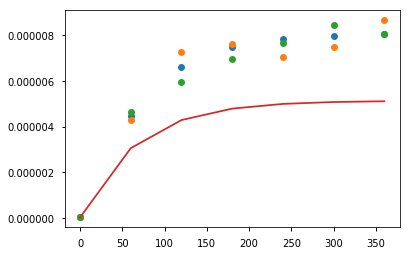

In [4]:
# Part 2: Integrate model using a set of parameters

y_init  = [0, 2.5e-8]
values  = {'inducer' : 1,
           'synm1'   : 2e-5,  
           'k_ind'   : 12, 
           'degm'    : 0.2,  
           'synp'    : 0.01e-4, #Value changed for model fitting
           'mu'      : 0.015
          }
params     = list(values.values())
tspan= [0, 60, 120, 180, 240, 300, 360]
model_data = odeint(model, y_init, tspan, args=tuple([params]))
y_model    = model_data[:,1]

fig2 = plt.figure()
ax2  = fig2.add_subplot(1,1,1)
ax2.plot(tspan, y_data,'o')
ax2.plot(tspan, y_model)
setting = ax1.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')

In [5]:

#Part 3: Calculate error

SSE = 0
for column in y_data:
    SSE += np.sum((y_data[column]-y_model)**2)

print(SSE)

1.1758672600745508e-10


In [6]:
def get_SSE(tspan, y_data, params):
    model_data = odeint(model, y_init, tspan, args=tuple([params]))
    y_model    = model_data[:,1]
    
    SSE = 0
    for column in y_data:
        SSE += np.sum((y_data[column]-y_model)**2)
    
    return SSE

In [7]:
print(get_SSE(tspan, y_data, params))


1.1758672600745508e-10


In [8]:
def objective_function_wrapper(tspan, y_data, inducer):
    def helper(params):
        #Inducer concentration is fixed at 1.
        params_ = [1] + list(params)
        return get_SSE(tspan, y_data, params)
    return helper

In [9]:
#Wrap get_SSE
objective_function = objective_function_wrapper(tspan, y_data, params[0])
#This function now takes in the params as the sole argument and returns the SSE.

#Run optimizer.
x0     = list(params)[1:] #Remember not to include the inducer!
lw = [0,0,1,0,0,0]
up = [1,1,15,1,1,1]
result = dual_annealing(objective_function, bounds = list(zip(lw,up)), maxiter = 100000)
best_value  = result.fun
best_params = result.x
print(result)

     fun: 4.21597362614077e-12
 message: ['Maximum number of iteration reached']
    nfev: 1316267
    nhev: 0
     nit: 100000
    njev: 16598
  status: 0
 success: True
       x: array([6.43171837e-03, 3.02029155e-01, 1.22310895e+01, 8.56172992e-01,
       2.53646686e-04, 1.71647665e-02])


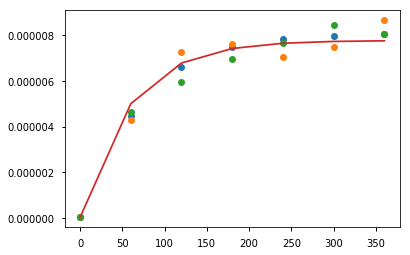

In [10]:
model_data = odeint(model, y_init, tspan, args=tuple([best_params]))
y_model    = model_data[:,1]

fig3 = plt.figure()
ax3  = fig3.add_subplot(1,1,1)
ax3.plot(tspan, y_data,'o')
ax3.plot(tspan, y_model)
setting = ax1.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')